In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz


In [4]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [5]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg' :'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest' : 'newBalanceDest'})
print(df.head(20))

    step      type     amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0      1   PAYMENT    9839.64  C1231006815       170136.00       160296.36   
1      1   PAYMENT    1864.28  C1666544295        21249.00        19384.72   
2      1  TRANSFER     181.00  C1305486145          181.00            0.00   
3      1  CASH_OUT     181.00   C840083671          181.00            0.00   
4      1   PAYMENT   11668.14  C2048537720        41554.00        29885.86   
5      1   PAYMENT    7817.71    C90045638        53860.00        46042.29   
6      1   PAYMENT    7107.77   C154988899       183195.00       176087.23   
7      1   PAYMENT    7861.64  C1912850431       176087.23       168225.59   
8      1   PAYMENT    4024.36  C1265012928         2671.00            0.00   
9      1     DEBIT    5337.77   C712410124        41720.00        36382.23   
10     1     DEBIT    9644.94  C1900366749         4465.00            0.00   
11     1   PAYMENT    3099.97   C249177573        20771.00      

Testing if there is any missing values in Data Frame

In [6]:
df.isnull().values.any()

False

### Exploratory Data Analysis

By using some  dataframe methods we will wrangle with data excluively. By thi we will gain some insight into the dataset

Question : Which types of transactions are fraudulent?

In [7]:
print('\n The types of fraudulent transaction are {}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]

dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print('\n The number of fraudulent TRANSFERs = {}'.format(len(dfFraudTransfer)))

print('\n The number of fraudulent CASH_OUTs = {}'.format(len(dfFraudCashout)))




 The types of fraudulent transaction are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


Question :  What determines whether the feature isFlaggedFraud gets set or not?



In [8]:
CountisFlaggedFraud = df.loc[(df.isFlaggedFraud == 1)]

CountisFlaggedFraudWithTransfer = df.loc[(df.isFlaggedFraud == 1) & (df.type == 'TRANSFER')]

print(len(CountisFlaggedFraud))
print(len(CountisFlaggedFraudWithTransfer))
print(df.shape)
print(CountisFlaggedFraudWithTransfer)

print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates())))


dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\n The minimum amount transacted when isFlaggedFraud is set ={}'.format(dfFlagged.amount.min()))

print('\n The max amount transacted when isFlaggedFraud is set ={}'.format(dfFlagged.amount.max()))

print('\nThe max amount is TRANSFERED when isFlaggedFraud is NOT set ={}'.format(dfNotFlagged.amount.max()))

16
16
(6362620, 11)
         step      type       amount     nameOrig  oldBalanceOrig  \
2736446   212  TRANSFER   4953893.08   C728984460      4953893.08   
3247297   250  TRANSFER   1343002.08  C1100582606      1343002.08   
3760288   279  TRANSFER    536624.41  C1035541766       536624.41   
5563713   387  TRANSFER   4892193.09   C908544136      4892193.09   
5996407   425  TRANSFER  10000000.00   C689608084     19585040.37   
5996409   425  TRANSFER   9585040.37   C452586515     19585040.37   
6168499   554  TRANSFER   3576297.10   C193696150      3576297.10   
6205439   586  TRANSFER    353874.22  C1684585475       353874.22   
6266413   617  TRANSFER   2542664.27   C786455622      2542664.27   
6281482   646  TRANSFER  10000000.00    C19004745     10399045.08   
6281484   646  TRANSFER    399045.08   C724693370     10399045.08   
6296014   671  TRANSFER   3441041.46   C917414431      3441041.46   
6351225   702  TRANSFER   3171085.59  C1892216157      3171085.59   
6362460   730 

There are only 16 entries out of 6 million where the isFlaggedFraud is set. So, it do not seen to correlete with any exploratory variable.

But the isFlaggedFraud is set only whean an attempt is made to 'TRANSFER' an amount grater than 2lakhs.

In fact there are many cases in which both theres are satisfying but the Flag is NOT set.


The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set. This is presumably because the transaction is halted. Interestingly, oldBalanceDest = 0 in every such transaction. However, as shown below, since isFlaggedFraud can remain not set in TRANSFERS where oldBalanceDest and newBalanceDest can both be 0, these conditions do not determine the state of isFlaggedFraud.

In [9]:
#print('The no. of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0 is : {}'.format(len(dfTransfer.loc[(dfTransfer.isFlaggedFruad == 0) & (dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)])))
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: {}'.format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)]))) 


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


Now We will look at oldBalanceOrig file


In [10]:
print('\n Min, Max of OldBalanceOrig for isFlaggedFraud = 1 Transfers are : {}'.format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('\n Min, Max of oldBalanceOrig of isFlaggedFraud = 0 Transfers where oldBalanceOrig = newBalanceOrig : {}'.format([dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) 
                                                                                                                                       & (dfTransfer.oldBalanceOrig == dfTransfer.newBalanceOrig)].oldBalanceOrig.min(),
                                                                                                                        round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))


 Min, Max of OldBalanceOrig for isFlaggedFraud = 1 Transfers are : [353874.0, 19585040.0]

 Min, Max of oldBalanceOrig of isFlaggedFraud = 0 Transfers where oldBalanceOrig = newBalanceOrig : [0.0, 575668.0]


Can isFlaggedFraud be set based on seeing a customer transacting more than once? 
duplicate customer names don't exist within transactions where isFlaggedFraud is set, but duplicate customer names exist within transactions where isFlaggedFraud is not set. 


let's check that isFlaggedFraud have transacted the money and used the same destination account more than one time.



In [11]:
print('\nHave Originators of transactions flagged as fraud transacted more than once? {}'
      .format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig,dfNotFlagged.nameDest]))).any()))


print('\nHave destinations for transactions flagged as fraud initiated other transactions? {}'
      .format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any()))


print('\nHow many destination accounts of transactions as flagged as fraud have been destination accounts more than once?: {}'
     .format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest))))


Have Originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions as flagged as fraud have been destination accounts more than once?: 2


It turns out that originators of transactions that have isFlaggedFraud set have transacted only once. Very few destination accounts of transactions that have isFlaggedFraud set have transacted more than once.

Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been destination accounts more than once, clearly 'isFlaggedFraud' being set is independent of whether a destination account has been used before or not

#### Conclusion
Although isFraud is always set when isFlaggedFraud is set, since isFlaggedFraud is set just 16 times in seemingly meaningless way, we can treat this feature as insignificant and discard it in the dataset without loosing information.

### let's visualize merchant accounts

It was stated that CASH_IN involves being paid by a merchant(whose name is prefixed by 'M')

In [15]:
#Checking are there any merchant accounts for Cash_in transaction

print('\nAre there any merchants among originators accounts for CASH_IN transactions? {}'
     .format((df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any()))


Are there any merchants among originators accounts for CASH_IN transactions? False


Similarly, It was stated that CASH_OUT involves paying a merchant. However for CASH_OUT transactions there are no merchants among the destination accounts.


In [16]:
print('\nAre there any merchants among destination accounts for CASH_OUT transactions? {}'.format((df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any()))


Are there any merchants among destination accounts for CASH_OUT transactions? False


In [18]:
#let's check if there are any merchants among originators accounts?

print('\nAre there are any merchants accounts among any originator accounts?\n{}'
     .format(df.nameOrig.str.contains('M').any()))


# Let's check are there any transactions having merchants among destination accounts other than the PAYMENT type


print('\nAre there any transactions having merchants among destination accounts other than the PAYMENT type?\n{}'
      .format((df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any()))


Are there are any merchants accounts among any originator accounts?
False

Are there any transactions having merchants among destination accounts other than the PAYMENT type?
False


#### Conclusion

Among the accounts labels nameOrig and nameDest, for all transactions, the merchant prefix of 'M' occurs in an unexpacted way

##### Are the accounts labels common to fraudulent TRANSFERs and CASH_OUTs?



this type of frauds involves first making a TRANSFER to a fraudlent account which in turn conducts a CASH_OUT involves transacting with a merchant who pays out cash. thus within two stps process the fraudulent account would be both, the destination in a TRANSFER and the originator in a CASH_OUT.However, the data is nott imprinted with the expected modus-operandi

In [20]:
print('\nWithin fraudlent transactions, are there destinations for TRANSFERs that are also originators for CASH_OUTs?\n{}'
     .format((dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any()))

dfNotFraud = df.loc[df.isFraud == 0]


Within fraudlent transactions, are there destinations for TRANSFERs that are also originators for CASH_OUTs?
False


###### Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that are not detected and are labeled as genuine?

In [21]:
print('\nFraudlent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs:\n\n{}'
     .format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))



Fraudlent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs:

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


#### Conclusion

The nameOrig and nameDest features neither encode merchant accounts in the expected way, we drop these features from the data since they are meaningless

#### Data Cleaning

We know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X for analysis.

In [23]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

######  Imputation of Latent Missing Values

In [33]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0


The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%)

Labeling the data

In [34]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), 
      ['oldBalanceDest', 'newBalanceDest']] = - 1

In [35]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), 
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

##### Feature-engineering

In [36]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

##### Data visualization

The best way of confirming that the data contains enough information so that a ML algorithm can make strong predictions, is to try and directly visualize the differences between fraudulent and genuine transactions. Motivated by this principle, I visualize these differences in several ways in the plots below

In [37]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, 
             hue = hue, jitter = 0.4, marker = '.', 
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), 
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

###### Dispersion over time

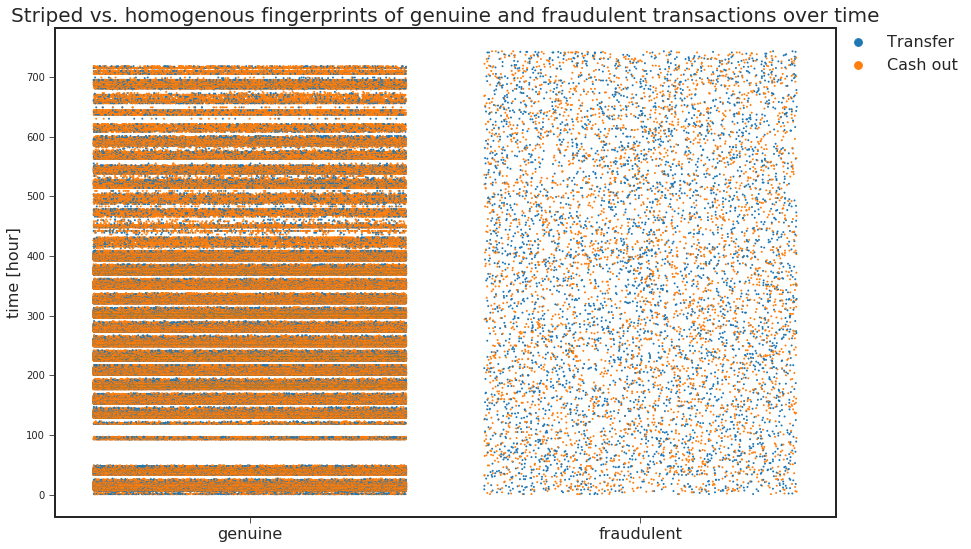

In [29]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time', size = 20);

The plot above shows how the fraudulent and genuine transactions yield different fingerprints when their dispersion is viewed over time. It is clear that fradulent transactions are more homogenously distributed over time compared to genuine transactions. Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions. Note that the the width of each 'fingerprint' is set by the 'jitter' parameter in the plotStrip function above which attempts to separate out and plot transactions occuring at the same time with different abscissae

###### Dispersion over amount

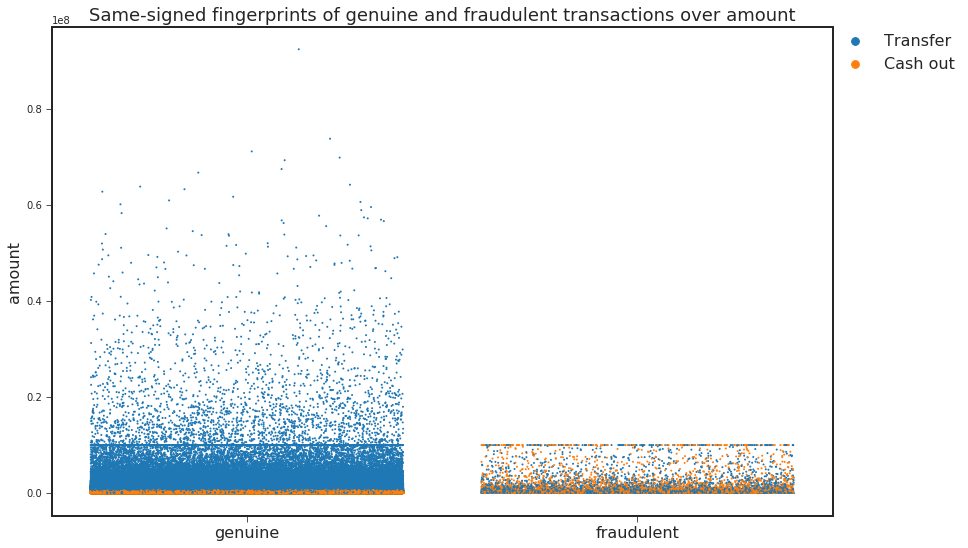

In [38]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

The two plots above shows that although the presence of fraud in a transaction can be discerned by the original amount feature, the new errorBalanceDest feature is more effective at making a distinction

###### Dispersion over error in balance in destination accounts

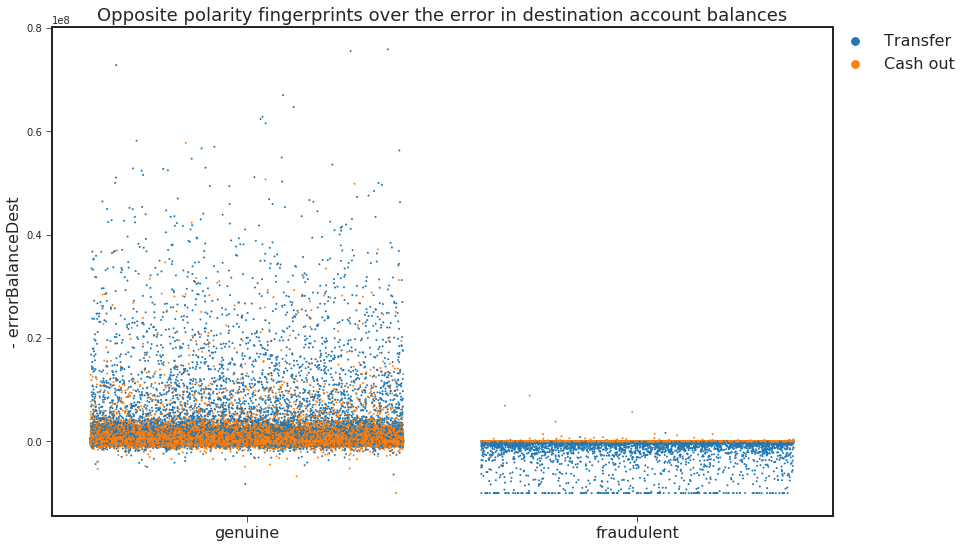

In [39]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

###### Separating out genuine from fraudulent transactions

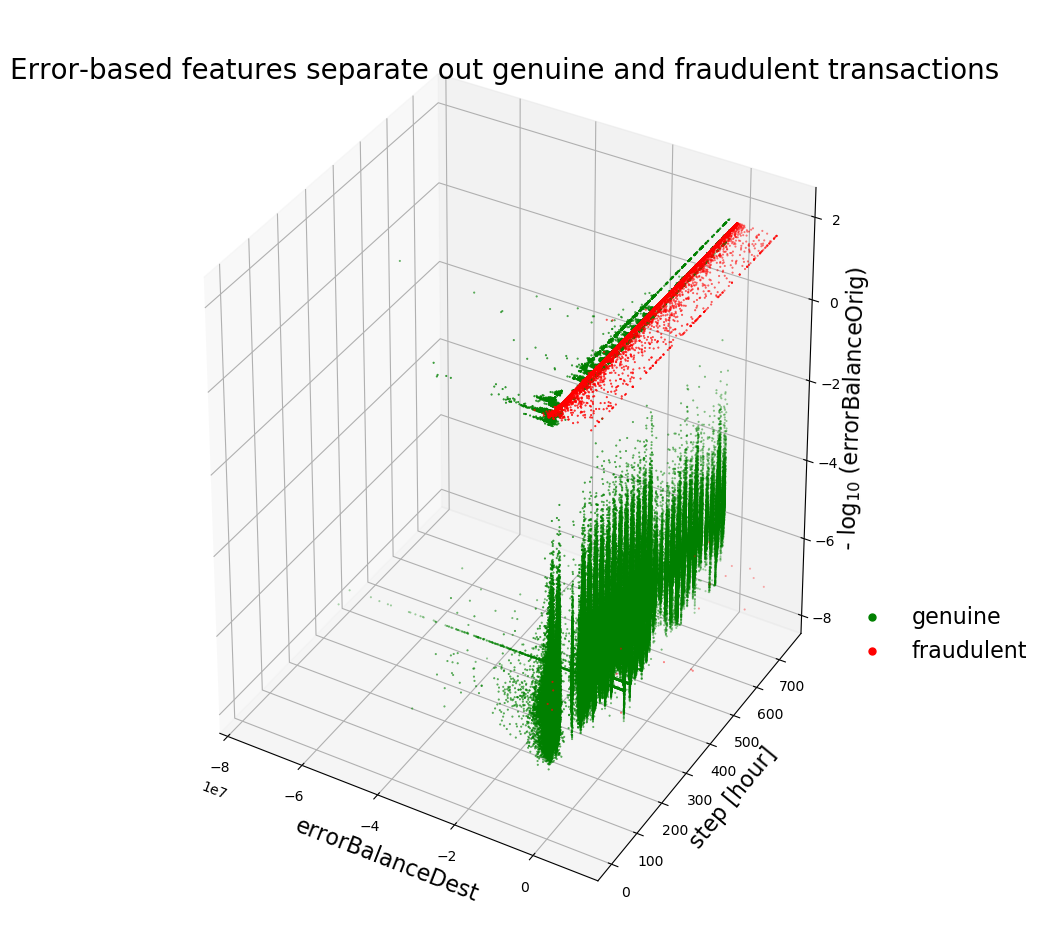

In [40]:
#long computatuiton time (copied code)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

The 3D plot below distinguishes best between fraud and non-fraud data by using both of the engineered error-based features. Clearly, the original step feature is ineffective in seperating out fraud. Note the striped nature of the genuine data vs time which was aniticipated from the 3D figure in section.

##### Machine Learning to Detect Fraud in Skewed Data

Having obtained evidence from the plots above that the data now contains features that make fraudulent transactions clearly detectable, the remaining obstacle for training a robust ML model is the highly imbalanced nature of the data.

In [41]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


###### Selection of ML algorithm

The best result is obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. Among these algorithms, the extreme gradient-boosted (XGBoost) algorithm used below slightly outperforms random-forest. Finally, XGBoost, like several other ML algorithms, allows for weighting the positive class more compared to the negative class --- a setting that also allows to account for the skew in the data.

In [42]:
#Split the data into training and test sets in a 80:20 ratio

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [43]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9986361116985445


###### What are the important features for the ML model?



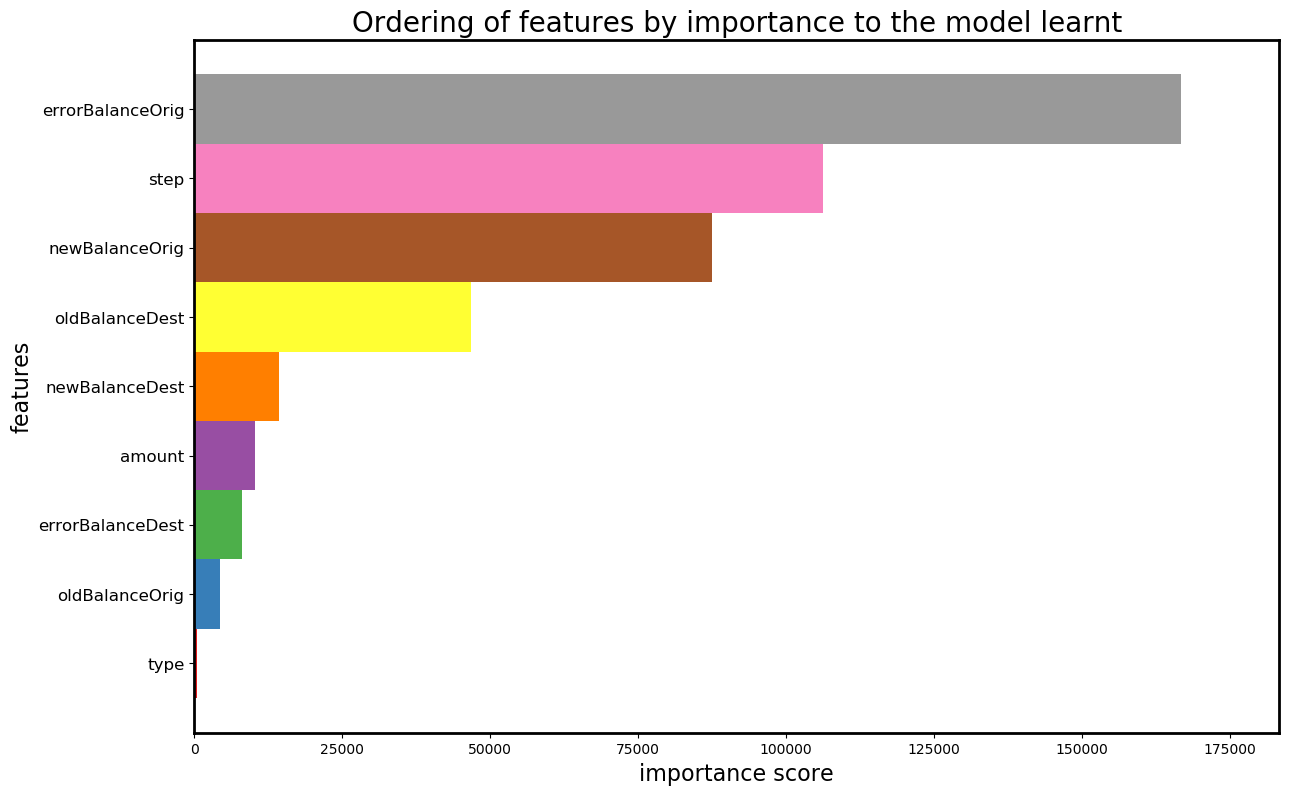

In [46]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

The figure above shows that the new feature errorBalanceOrig that we created is the most relevant feature for the model. The features are ordered based on the number of samples affected by splits on those features.


In [44]:
#long computation
trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

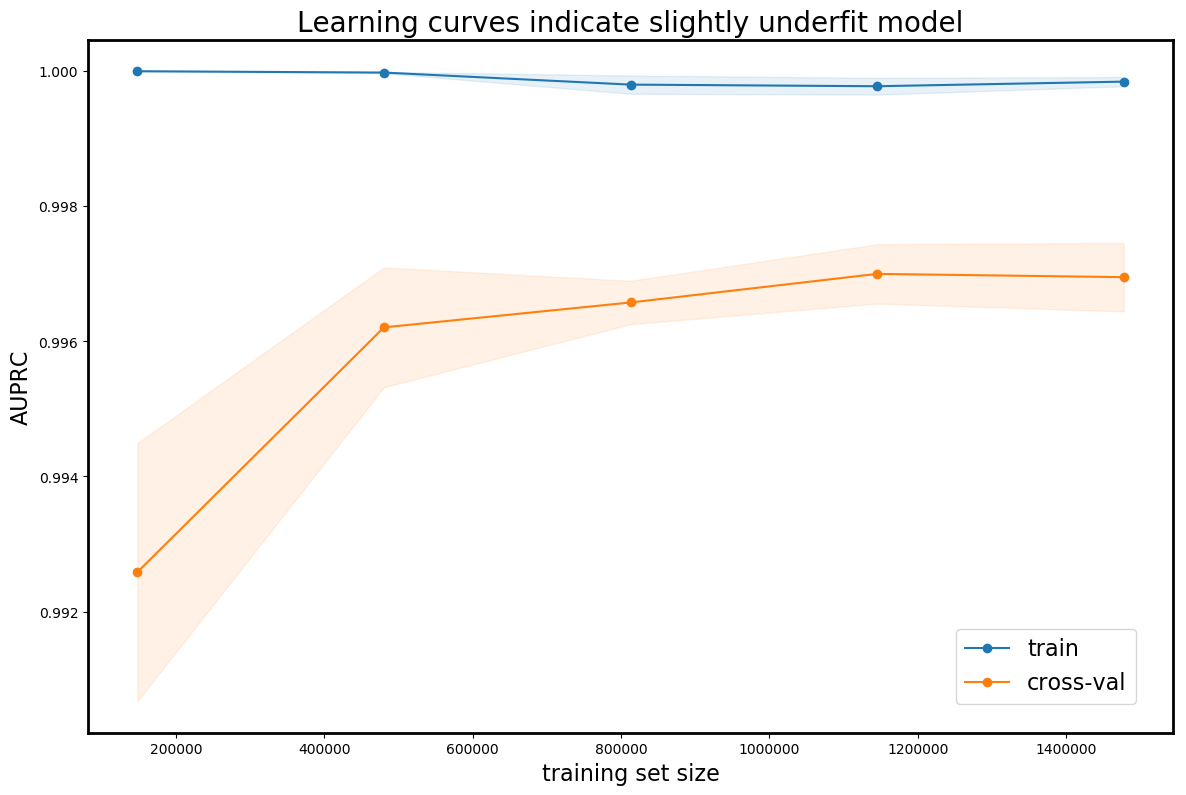

In [45]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

##### Conclusion
The plots provided visual confirmation that the data could be indeed be discriminated with the aid of the new features. To deal with the large skew in the data, we chose an appropriate metric and used an ML algorithm based on an ensemble of decision trees which works best with strongly imbalanced classes